# Time Series forecasting with XGBoost

## Table of content
1. [Library ](#library )
2. [Data](#data)
3. [Create Time Series Features & lagging features](#features)
4. [Train/Test Data Split](#train_test)
5. [XGBoost Model](#model)
- [Feature Importances](#importances)
6. [Forecast on Test Set](#forecast)
7. [Error Metrics On Test Set](#error)

### Library <a id="library"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

### Data<a id="data"></a>

In [2]:
df=pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

df.head()

C:\Users\vudin\AppData\Local\Temp\ipykernel_10092\611464619.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df=pd.read_csv('household_power_consumption.txt', sep=';',
C:\Users\vudin\AppData\Local\Temp\ipykernel_10092\611464619.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df=pd.read_csv('household_power_consumption.txt', sep=';',


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [3]:
#đếm số lượng giá trị thiếu (NaN) trong mỗi cột của DataFrame df
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [4]:
#điền các giá trị thiếu bằng giá trị liền trước của nó.
df['Global_active_power'] = df['Global_active_power'].replace('?', np.nan)

newdf = df.copy()
newdf.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

### Create Time Series Features & lagging features<a id="features"></a>

In [5]:
#định nghĩa hàm có tên là encode để mã hóa các biến với phương pháp mã hóa góc
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    data.drop(col,axis=1,inplace = True)
    return data

In [6]:
# Set 15 minutes as a lagging time unit, therefore lagging time will be 15 min * n, such as 15 min, 30 min, 1 hour and so on. 
# The smaller this lagging time unit is, the better the predicting result is. 

def get_lag(data, col, lagtime):
    for i in range(1,lagtime+1):
        if len(pd.Series(col)) == 1:
            data[col+"_lag"+str(i)] = data[col].shift(i*15)
        else:
            for col_j in col:
                data[col_j+"_lag"+str(i)] = data[col_j].shift(i*15)
    return data

Các cột thời gian như 'hour', 'dayofweek', 'month', 'dayofyear' và 'dayofmonth' đã được mã hóa thành các cột góc mới, giúp giữ lại thông tin về mối quan hệ góc giữa các giá trị thời gian

In [7]:
# Create Time Series Features 

newdf['date'] = newdf.index

newdf['hour'] = newdf['date'].dt.hour
newdf = encode(newdf,'hour',24)

newdf['dayofweek'] = newdf['date'].dt.dayofweek
newdf = encode(newdf,'dayofweek',7)

newdf['month'] = newdf['date'].dt.month
newdf = encode(newdf,'month',12)

# newdf['year'] = newdf['date'].dt.year

newdf['dayofyear'] = newdf['date'].dt.dayofyear
newdf = encode(newdf,'dayofyear',365)

newdf['dayofmonth'] = newdf['date'].dt.day
newdf = encode(newdf,'dayofmonth',31)

#newdf['weekofyear'] = newdf['date'].dt.weekofyear

newdf.drop('date',axis=1,inplace = True)

In [8]:
# adding lagging feature

# adding time lags of 15min,30min as features
#Định nghĩa giá trị thời gian trễ (lag time) là 2, tức là chúng ta sẽ tạo các đặc trưng dựa trên dữ liệu 2 giờ trước đó
lagtime = 2
lag_feature = ['Global_reactive_power','Voltage', 'Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']
newdf = get_lag(newdf, lag_feature, lagtime)

# adding time lags of 2 hours as features

newdf = get_lag(newdf, 'Global_active_power', 8)

newdf.drop(lag_feature,axis=1,inplace = True)

newdf.dropna(inplace=True)

In [9]:
newdf.head()

,Global_active_power,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos,dayofyear_sin,dayofyear_cos,dayofmonth_sin,...,Sub_metering_2_lag2,Sub_metering_3_lag2,Global_active_power_lag1,Global_active_power_lag2,Global_active_power_lag3,Global_active_power_lag4,Global_active_power_lag5,Global_active_power_lag6,Global_active_power_lag7,Global_active_power_lag8
dt,,,,,,,,,,,,,,,,,,,,,
2006-12-16 19:24:00,3.262,-0.965926,0.258819,-0.974928,-0.222521,-2.449294e-16,1.0,-0.255353,0.966848,-0.101168,...,1.0,16.0,3.394,4.298,2.326,3.452,4.464,2.720,3.384,4.216
2006-12-16 19:25:00,3.476,-0.965926,0.258819,-0.974928,-0.222521,-2.449294e-16,1.0,-0.255353,0.966848,-0.101168,...,1.0,17.0,3.400,4.230,2.264,4.870,3.396,3.758,3.270,5.360
2006-12-16 19:26:00,3.620,-0.965926,0.258819,-0.974928,-0.222521,-2.449294e-16,1.0,-0.255353,0.966848,-0.101168,...,2.0,16.0,3.414,4.230,2.270,4.868,3.090,4.342,3.430,5.374
2006-12-16 19:27:00,3.610,-0.965926,0.258819,-0.974928,-0.222521,-2.449294e-16,1.0,-0.255353,0.966848,-0.101168,...,1.0,17.0,3.432,3.924,2.258,4.866,3.730,4.512,3.266,5.388
2006-12-16 19:28:00,3.646,-0.965926,0.258819,-0.974928,-0.222521,-2.449294e-16,1.0,-0.255353,0.966848,-0.101168,...,1.0,17.0,3.418,4.218,2.188,3.176,2.308,4.058,3.728,3.666


### Train/Test Data Split<a id="train_test"></a>

In [10]:
split_date =pd.to_datetime( '2009-11-26')
df_train = newdf.loc[newdf.index <= split_date].copy()
df_train.shape

(1538184, 31)

In [11]:
df_test = newdf.loc[newdf.index > split_date].copy()

df_test.shape

(508655, 31)

In [12]:
# The target is forecasting Global_active_power.
X_train, y_train = df_train.iloc[:,1:],df_train.iloc[:,0]
X_test, y_test = df_test.iloc[:,1:],df_test.iloc[:,0]

### XGBoost Model<a id="model"></a>

In [13]:
#Tạo một đối tượng XGBRegressor với tham số n_estimators được thiết lập là 1000. 
#Đây là số lượng cây quyết định (decision trees) trong mô hình XGBoost.
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        # Thiết lập số vòng lặp (rounds) mà mô hình sẽ kiểm tra liệu hiệu suất trên tập kiểm tra có cải thiện hay không.
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

C:\Users\vudin\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

#### Feature Importances<a id="importances"></a>

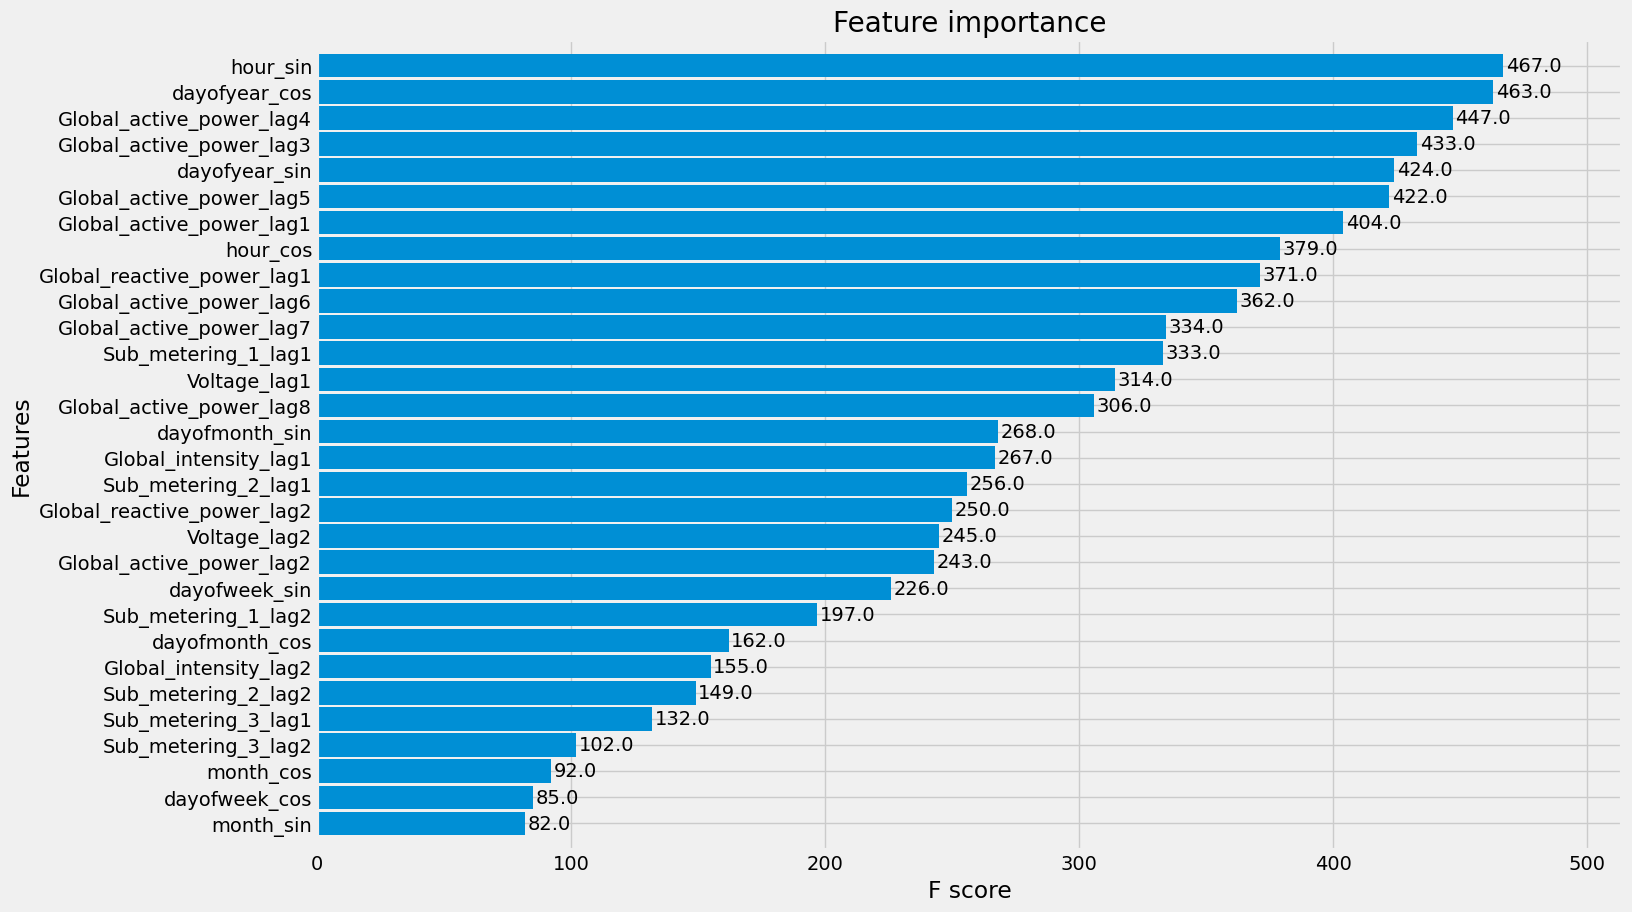

In [14]:
#hiển thị độ quan trọng của các đặc trưng trong mô hình đã huấn luyện sử dụng XGBoost Regressor
f, ax = plt.subplots(figsize=(15,10))
_ = plot_importance(reg, height=0.9,ax = ax)
plt.show()

### Forecast on Test Set<a id="forecast"></a>

In [15]:
df_test['Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

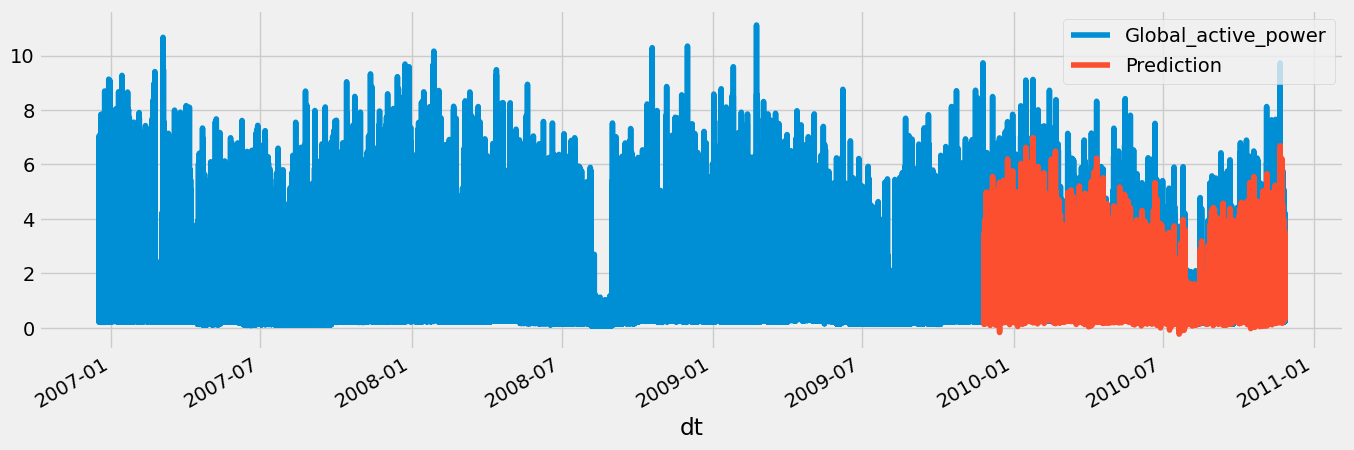

In [16]:
_ = df_all[['Global_active_power','Prediction']].plot(figsize=(15, 5))

### Error Metrics On Test Set<a id="error"></a>

In [17]:
mean_squared_error(y_true=df_test['Global_active_power'],
                   y_pred=df_test['Prediction'])

0.3267262390335025

RMSE: 0.3267262390335025